Dodane pakiety

In [136]:
import numpy as np
import pywt
import pywt.data
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

Import obrazu wykorzystanego podczas operacji przetwarzania i zamiana typu z rgb na black-white

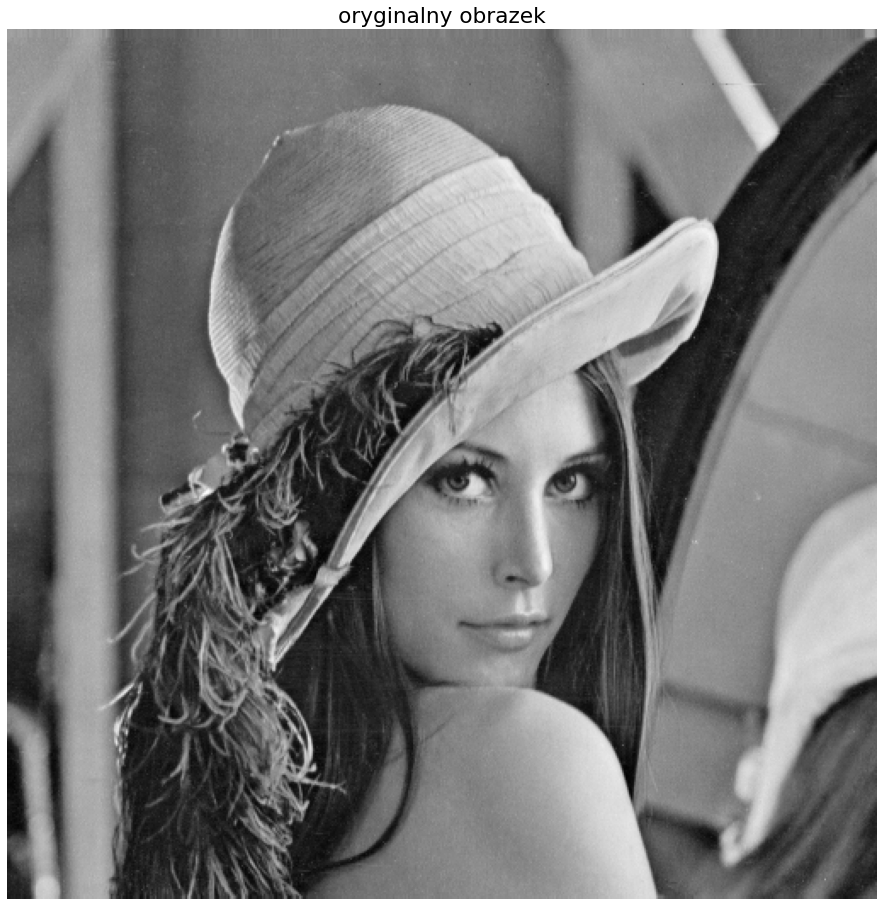

In [137]:
#ustawienie wielkości plotowanego obrazka
#plt.rcParams['figure.figsize'] = [16, 16]
#plt.rcParams.update({'font.size': 18})
plt.axis('off')

img = mpimg.imread('Lenna.jpg')
img = np.mean(img,-1)#zamiana na obraz czarnobiały

#przetworzenie kolorowego obrazu Lenna na format czarno biały uint8
plt.imsave('lenaoriginal'+'.jpg',img,cmap = 'gray')
plt.title('oryginalny obrazek')
plt.imshow(img, cmap=plt.get_cmap("gray"))


Przypisanie poziomu dekompozycji i nazwy falki macierzystej wykorzystywanej w dalszych operacjach na obrazie

In [138]:
levels = (np.floor(np.log2(img.shape[0]))).astype(int)
#['db1','haar','bior3.8','coif2','db6']
waveletName = 'db1'

print(levels)

9


Wykonanie operacji wielowymiarowej dekompozycji za pomocą falek (poziom 1) (falka macierzysta: db1)

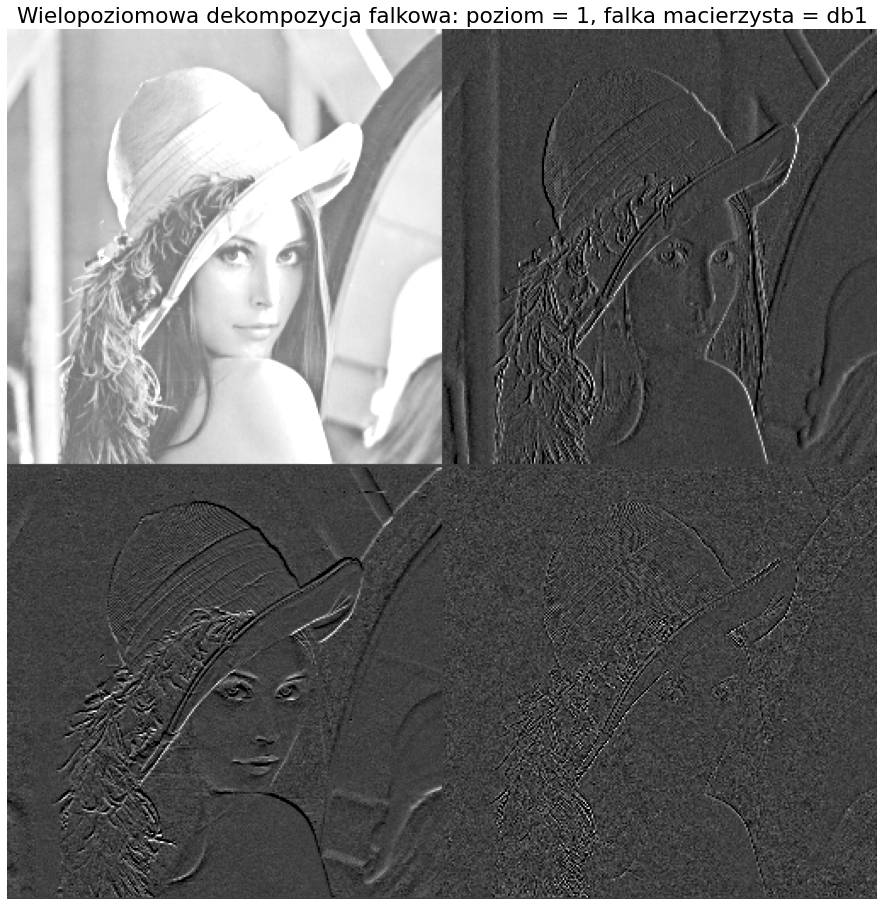

In [139]:
#tryb (zalecany 'periodization' dla każdego z obrazów)
#przetworzony obraz zostaje przechowany w formie listy gdzie elementy oznaczają następująco
#0 -> (array) warstwa przybliżająca danego poziomu falki
#1 -> (tuple3 of arrays) warstwa detali dla ostatniego poziomu dekompozycji 
wavelet_coeffs = pywt.wavedec2(img,wavelet=waveletName,level=1,mode='periodization',axes=(-2,-1))

wavelet_coeffs[0] /= np.abs(wavelet_coeffs[0]).max()
for detail_level in range(1):
    wavelet_coeffs[detail_level + 1] = [d/np.abs(d).max() for d in wavelet_coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(wavelet_coeffs)

plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)

plt.axis('off')
plt.title('Wielopoziomowa dekompozycja falkowa: poziom = 1, falka macierzysta = ' + waveletName)
plt.show()

Wykonanie operacji wielowymiarowej dekompozycji za pomocą falek (poziom 2) (falka macierzysta: db1)

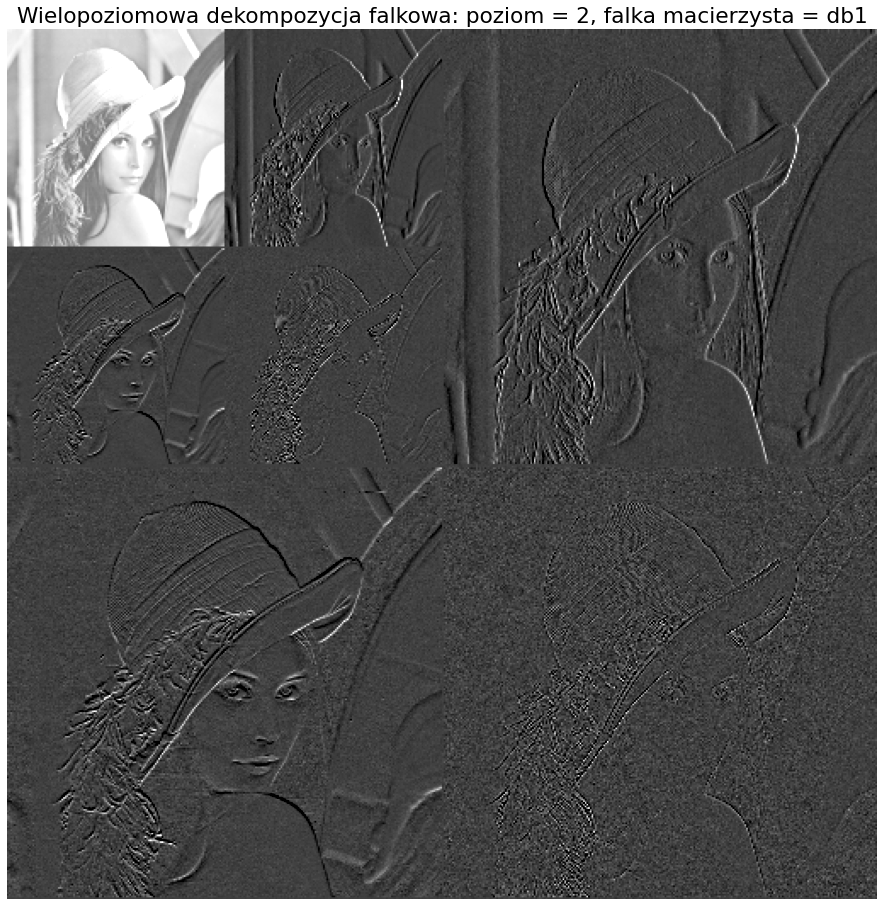

In [140]:
wavelet_coeffs = pywt.wavedec2(img,wavelet=waveletName,level=2,mode='periodization',axes=(-2,-1))

wavelet_coeffs[0] /= np.abs(wavelet_coeffs[0]).max()
for detail_level in range(2):
    wavelet_coeffs[detail_level + 1] = [d/np.abs(d).max() for d in wavelet_coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(wavelet_coeffs)

plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)

plt.axis('off')
plt.title('Wielopoziomowa dekompozycja falkowa: poziom = 2, falka macierzysta = ' + waveletName)
plt.show()

Wykonanie operacji wielowymiarowej dekompozycji za pomocą falek (poziom: maksymalny) (falka macierzysta: db1)

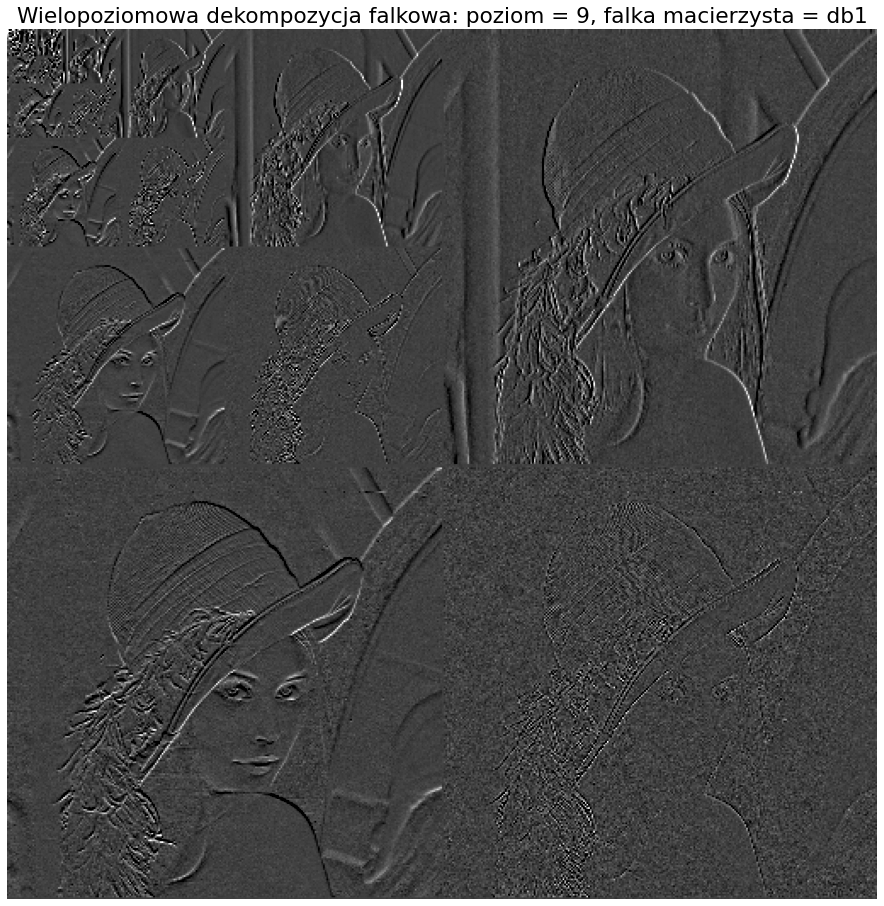

In [141]:
wavelet_coeffs = pywt.wavedec2(img,wavelet=waveletName,level=levels,mode='periodization',axes=(-2,-1))

wavelet_coeffs[0] /= np.abs(wavelet_coeffs[0]).max()
for detail_level in range(levels):
    wavelet_coeffs[detail_level + 1] = [d/np.abs(d).max() for d in wavelet_coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(wavelet_coeffs)

plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)

plt.axis('off')
plt.title('Wielopoziomowa dekompozycja falkowa: poziom = '+str(levels)+', falka macierzysta = ' + waveletName)
plt.show()

Wykonanie odwrotnej operecji wielopoziomowej dekompozycji

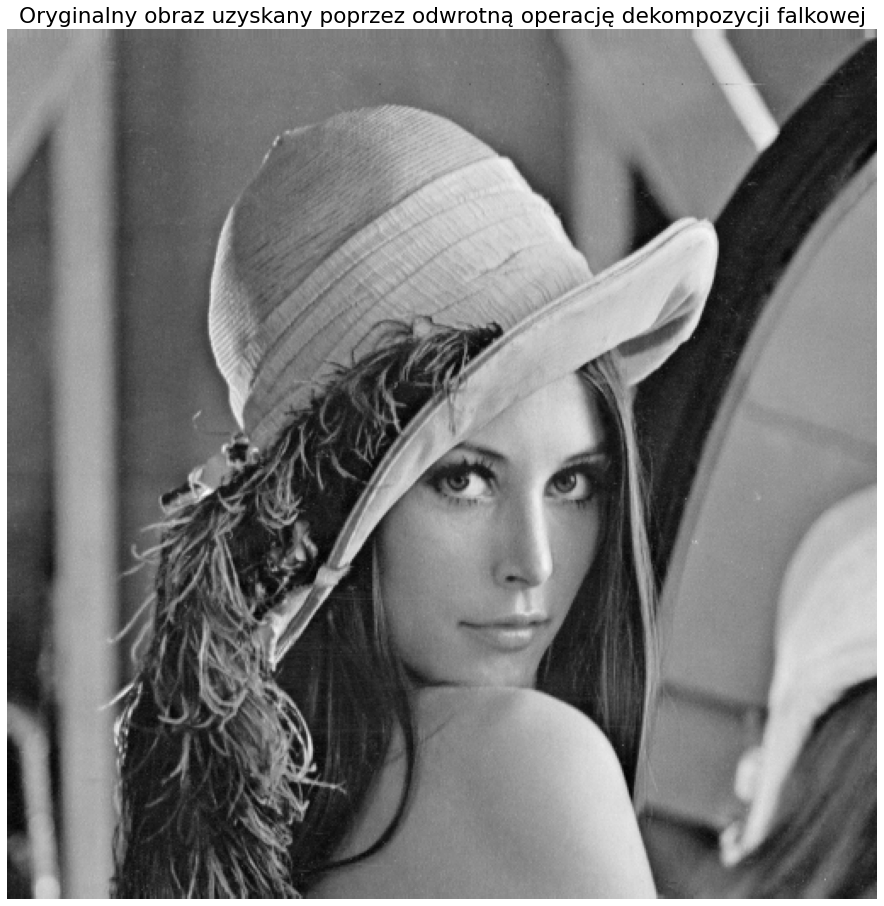

In [142]:
wavelet_coeffs = pywt.wavedec2(img,wavelet=waveletName,level=1,mode='periodization',axes=(-2,-1))

invarseOperationImage = pywt.waverec2(wavelet_coeffs,wavelet=waveletName,mode='periodization',axes=(-2,-1))

plt.axis('off')
plt.title('Oryginalny obraz uzyskany poprzez odwrotną operację dekompozycji falkowej')
plt.imshow(invarseOperationImage, cmap=plt.get_cmap("gray"))

Wykorzystanie falek do kompresji obrazu

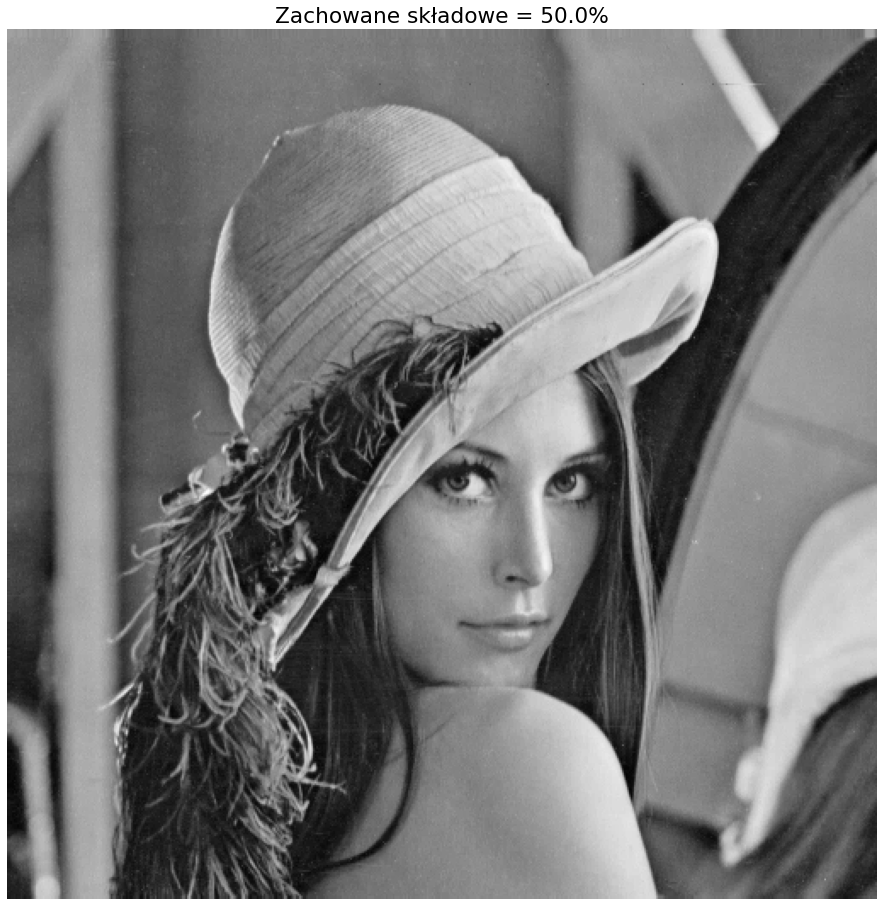

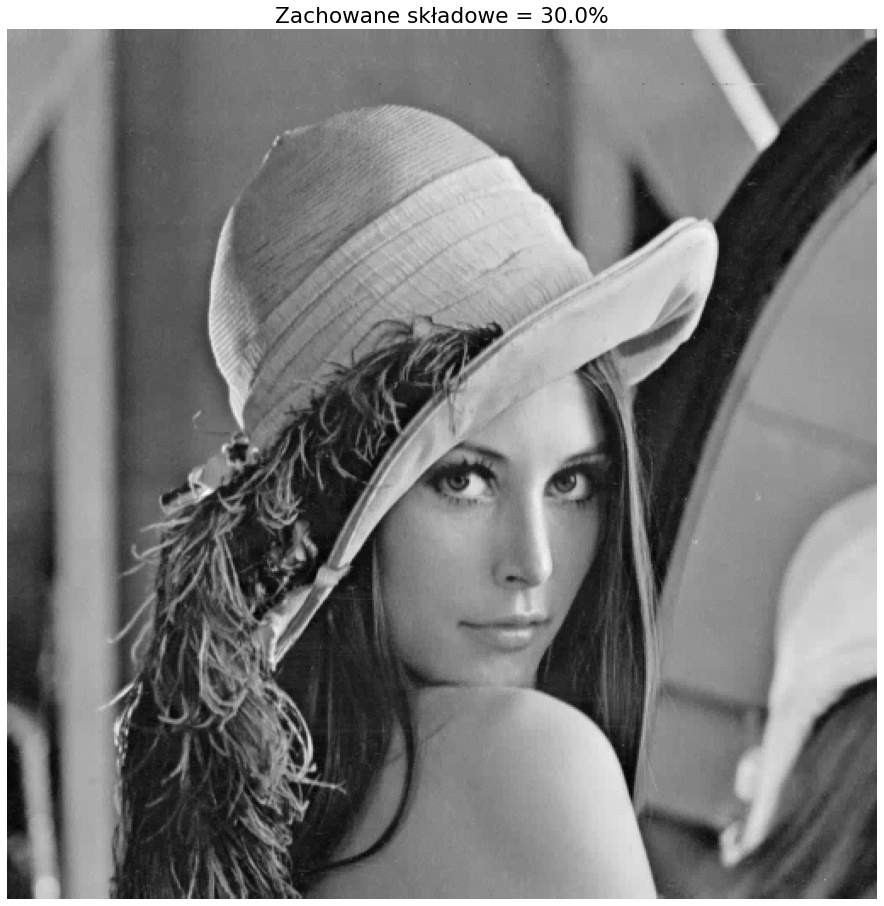

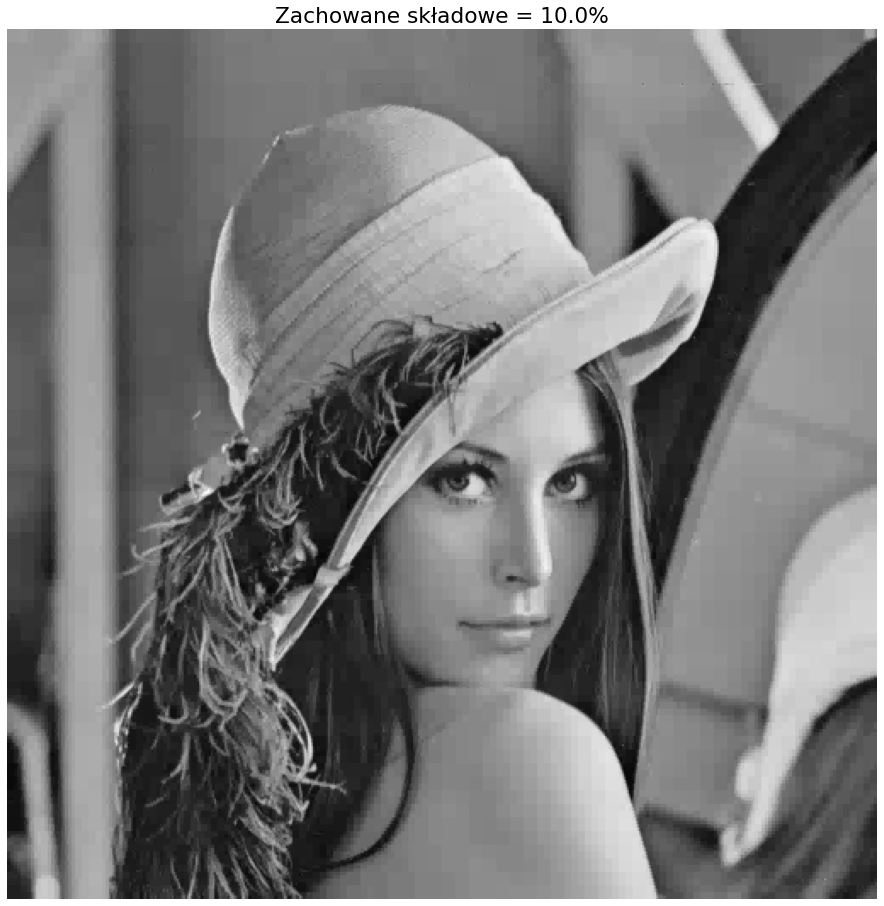

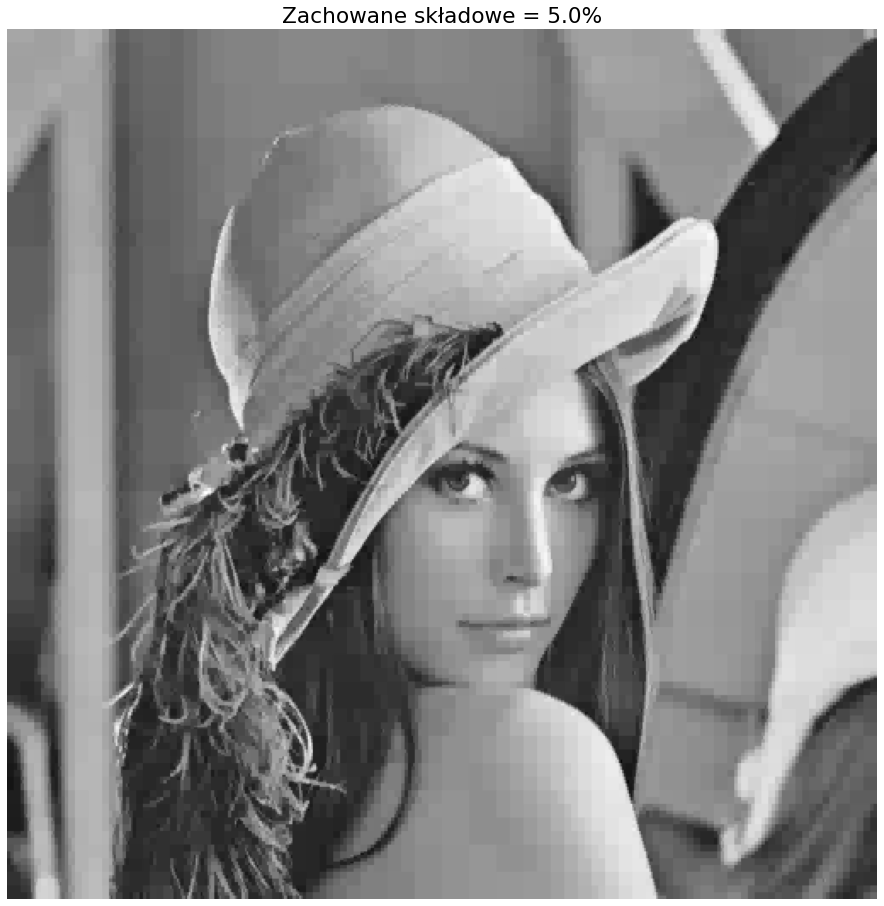

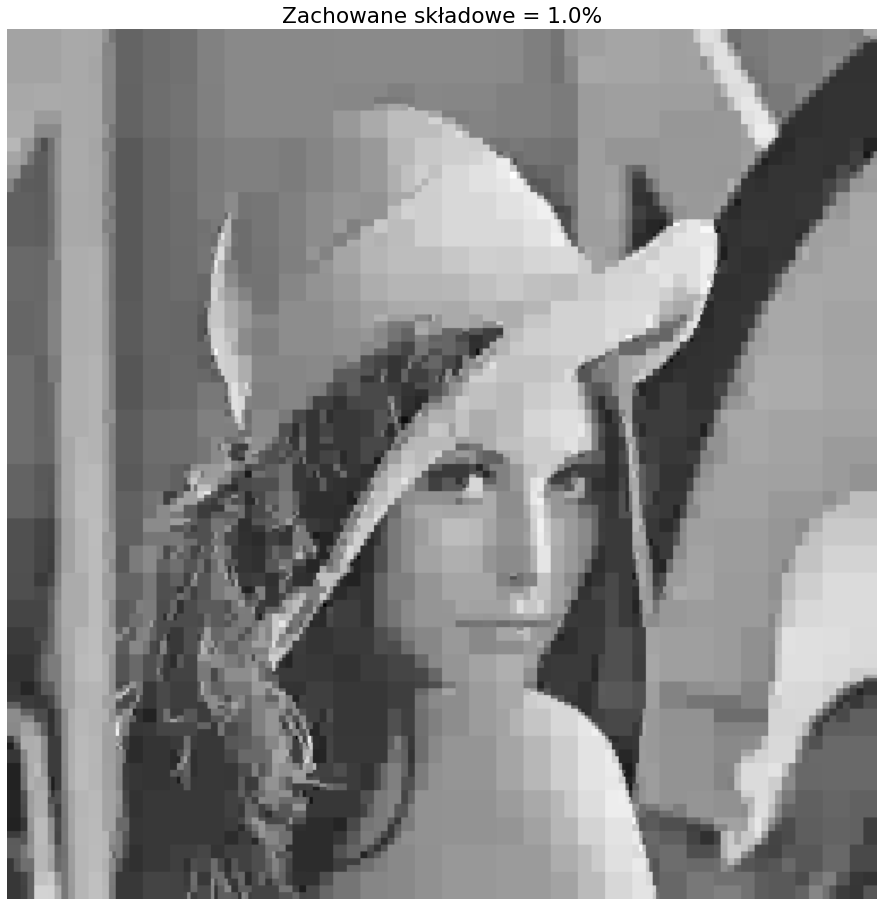

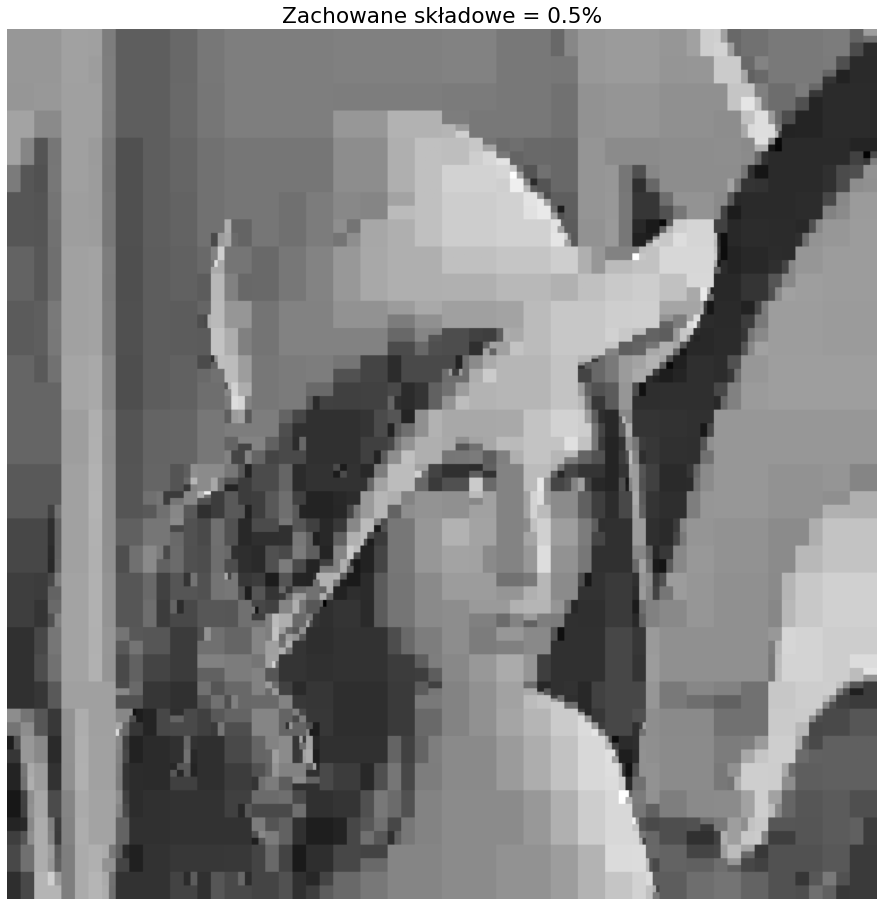

In [143]:
waveletName = 'db1'

coeffs = pywt.wavedec2(img,wavelet=waveletName,level=levels)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.5,0.3,0.1, 0.05, 0.01, 0.005):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind 

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')
    
    
    Arecon = pywt.waverec2(coeffs_filt,wavelet=waveletName)
    plt.figure()
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('Zachowane składowe = ' + str(keep*100)+'%')
    plt.imsave('lenacompressed'+str(keep)+'.png',Arecon.astype('uint8'),cmap = 'gray')

Wykorzystanie falek do odszumiania obrazu

Dodanie szumu do badanego zdjęcia

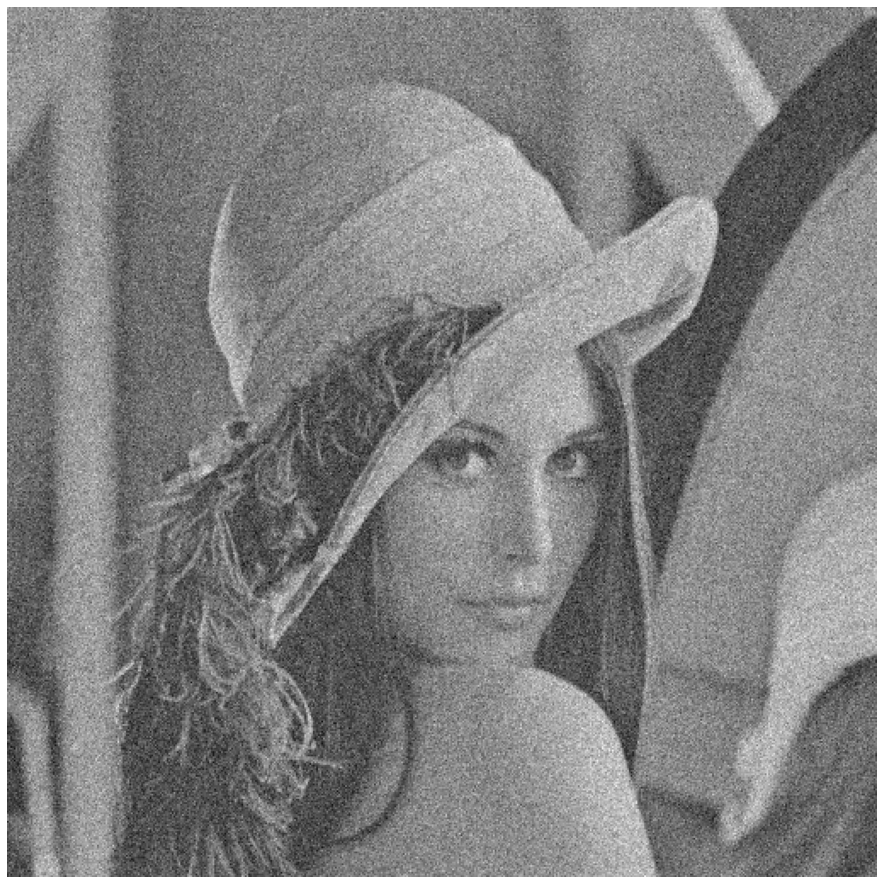

In [144]:
noiseSigma = 27.0
noisedImg = img.copy()
noisedImg += np.random.normal(0, noiseSigma, size=img.shape)

plt.axis('off')
plt.imshow(noisedImg, cmap=plt.get_cmap("gray"))

Implementacja funkcji odszumiającej obraz za pomocą operacji opartych na falkach

In [145]:
def denoiseImage(image, waveletLvl,waveletName,thresholdMode):
    #threshold = noiseSigma*np.sqrt(2*np.log2(image.size))
    threshold = estimate_sigma(image,average_sigmas = True)/0.8
    denoisedCoeffs = []
    waveletCoeffs = pywt.wavedec2( image, wavelet=waveletName, level=waveletLvl)
    print(len(waveletCoeffs))
    cA = waveletCoeffs[0]
    denoisedCoeffs.append(cA)

    detailCoeffs = waveletCoeffs[1:]
    
    for dC in detailCoeffs:
        c0,c1,c2 = dC
        c0 = pywt.threshold(c0,threshold,mode = thresholdMode)
        c1 = pywt.threshold(c1,threshold,mode = thresholdMode)
        c2 = pywt.threshold(c2,threshold,mode = thresholdMode)
        denoised_tupleDetails = (c0,c1,c2)
        denoisedCoeffs.append(denoised_tupleDetails)
    
    print(len(denoisedCoeffs))

    return pywt.waverec2(denoisedCoeffs, wavelet=waveletName)

Wykorzystanie funkcji denoiseImage w celu usunięcia zakłoceń w postaci szumu z obrazu

10
10


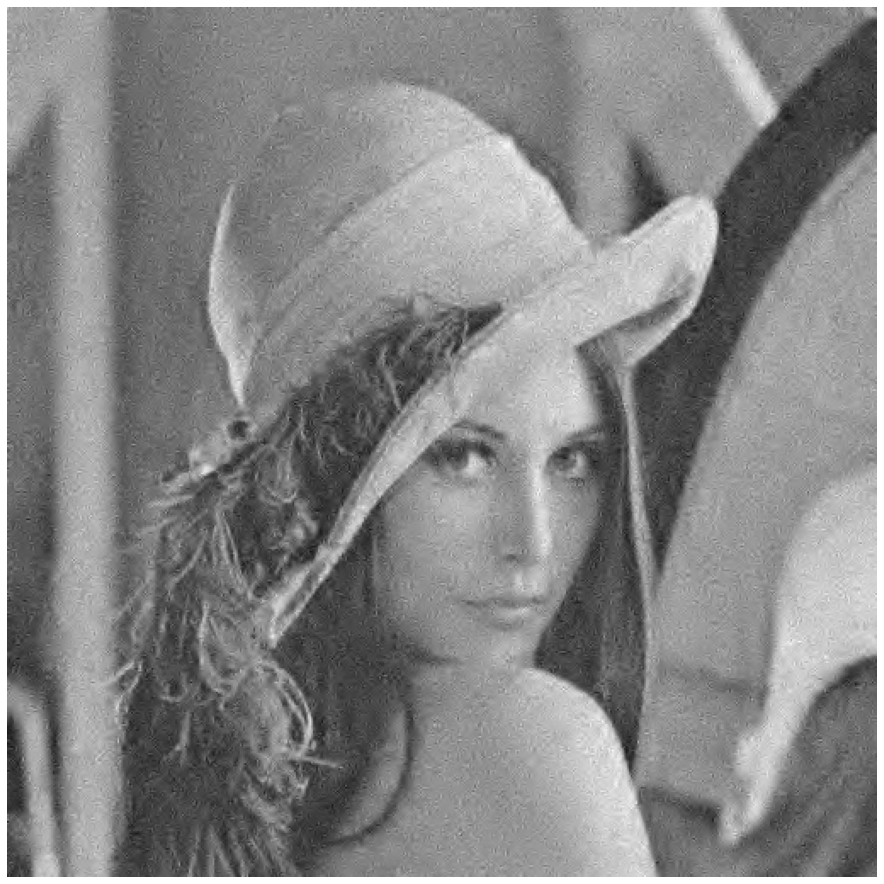

In [146]:
waveletName = 'bior6.8'
thresholdMODE = 'soft'

denoisedImage = denoiseImage(noisedImg,levels,waveletName,thresholdMODE)
plt.axis('off')
plt.imshow(denoisedImage, cmap=plt.get_cmap("gray"))

Wykorzystanie kryteriów załaczonych w pakiecie skimag w celu analizy jakości odszumiania

In [147]:
psnr_noisy = peak_signal_noise_ratio(img.astype('uint8'),noisedImg.astype('uint8'))
psnr_wavelet = peak_signal_noise_ratio(img.astype('uint8'),denoisedImage.astype('uint8'))
print('PSNR [Original vs Noisy Image]: ',psnr_noisy)
print('PSNR [Original vs Denoised Image]: ',psnr_wavelet)

PSNR [Original vs Noisy Image]:  18.668370348610747
PSNR [Original vs Denoised Image]:  27.188643459471823


Wykorzystanie falek w celu wykrywania krawędzi obrazu

Implementacja funkcji wykorzystywanej w celu progowanie obrazu (skala szarości -> (0,1))

In [148]:
def performThresholding(img_input,val_threshold,isFinalImg):
    low_values_indices = img_input < val_threshold
    img_input[low_values_indices] = 0

    if isFinalImg:
        low_values_indices = img_input > 0
        img_input[low_values_indices] = 255
    
    return img_input

Użycie funkcji performThreshholding na współczynnikach z detalami obrazu w celu zakcentowania krawędzi na obrazie

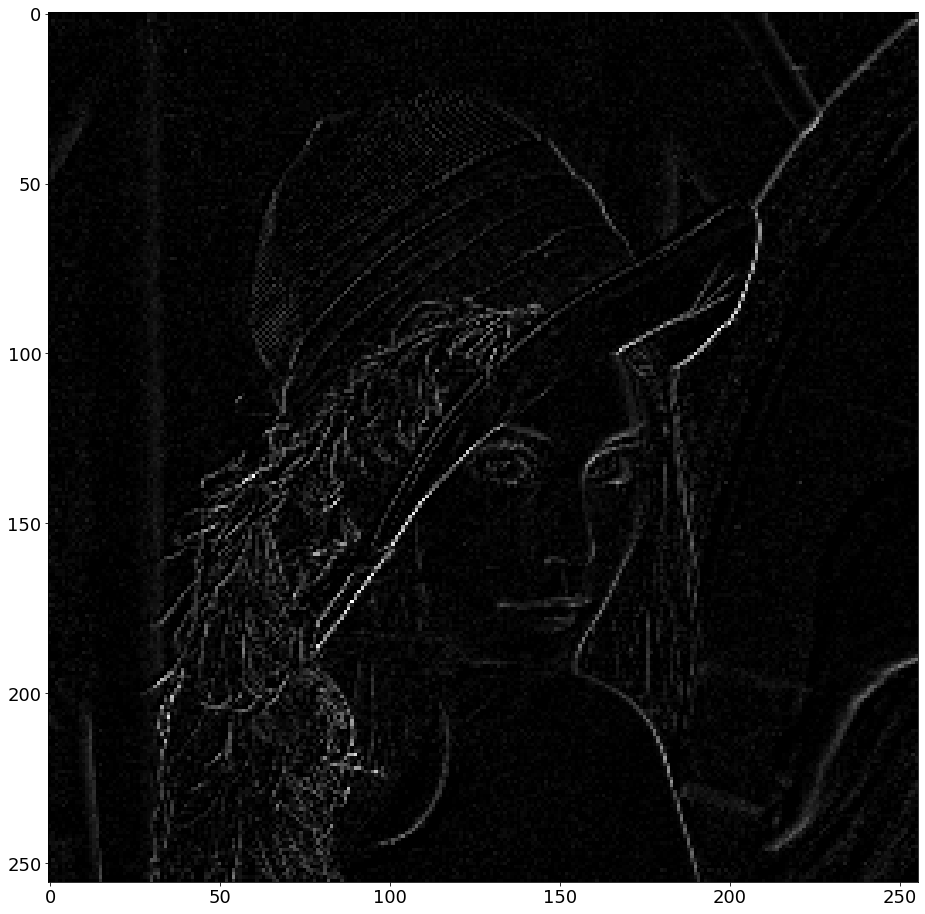

In [154]:
waveletName = 'db1'
wavelet_coeffs = pywt.wavedec2( img, wavelet=waveletName, level=levels)

wavelet_coeffs[0] /= np.abs(wavelet_coeffs[0]).max()
for detail_level in range(levels):
    wavelet_coeffs[detail_level + 1] = [d/np.abs(d).max() for d in wavelet_coeffs[detail_level + 1]]

cA = wavelet_coeffs[0]
(cH,cV,cD) = wavelet_coeffs[-1]

performThresholding(cH,0.01,False)
performThresholding(cV,0.01,False)
performThresholding(cD,0.01,False)

edgesImg = cH+cV+cD

plt.imshow(edgesImg, cmap=plt.get_cmap("gray"))

